# Flood Detection Methods

In [1]:
%matplotlib inline
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import ee; ee.Initialize()

# Configure the pretty printing output
pp = pprint.PrettyPrinter(depth=4)

In [2]:
# Landsat 8 scene from Iowa City, IA (2016)
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')
# Get metadata
# image.getInfo()

In [3]:
# Rename bands to something more understandable
l8t1_bands = ee.Dictionary({
    'B1': 'ultra_blue',
    'B2': 'blue',
    'B3': 'green',
    'B4': 'red',
    'B5': 'nir',
    'B6': 'swir1',
    'B7': 'swir2',
    'B8': 'pan',
    'B9': 'cirrus',
    'B10': 'tirs1',
    'B11': 'tirs2',
    'BQA': 'bqa'
})
band_names_new = l8t1_bands.values(image.bandNames())
band_names_original = image.bandNames()
image = image.select(band_names_original, band_names_new)

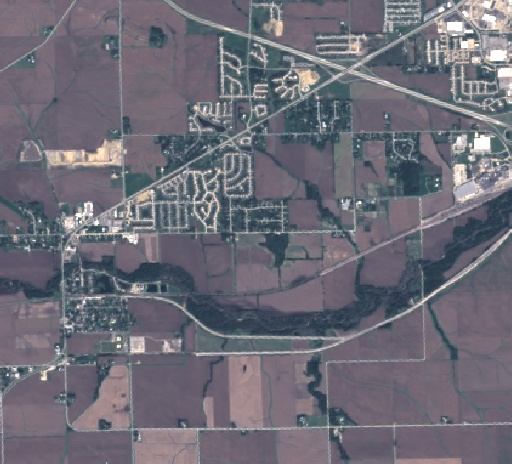

In [40]:
# Pansharpen the image to get a better resolution, then visualize
poly = ee.Geometry.Polygon(
    [[[-91.78812019737575, 41.95033307316587],
           [-91.79361336143825, 41.90333364712244],
           [-91.71739571007106, 41.9012894084067],
           [-91.72151558311793, 41.95288639774597]]])

def panSharpenL8(image):
    hsv = image.select('red', 'green', 'blue').rgbToHsv()
    sharpened = ee.Image.cat([hsv.select('hue'), 
                              hsv.select('saturation'), 
                              image.select('pan')]).hsvToRgb()
    return sharpened

# parameters for stretching
visparams = {'min':0,
             'max': 0.25,
#              'region':poly.getInfo()['coordinates'],
             'gamma': [1.3, 1.3, 1.3]}

sharpened = panSharpenL8(image)

# Get thumbnail URL from GEE server
url = sharpened.getThumbUrl(visparams) 
IPython.display.Image(url=url, format='png', embed=True)

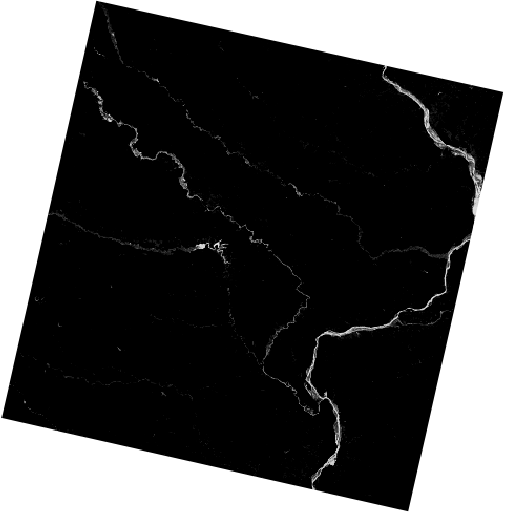

In [5]:
# Calculate MNDWI
green = image.select('green')
swir2 = image.select('swir2')
mndwi = green.subtract(swir2).divide(green.add(swir2)).rename('MNDWI')

# display mndwi
mndwiParams = {min: -1, max: 1}
url = mndwi.getThumbUrl(mndwiParams)
IPython.display.Image(url=url, format='png', embed=True)

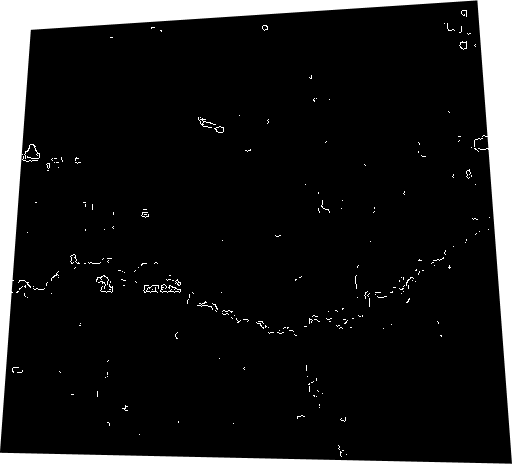

In [42]:
# Canny edge detection ... understand how this works
canny = ee.Algorithms.CannyEdgeDetector(mndwi, 0.99, 0)
canny = canny.clip(poly)
# bounds = ee.Feature()

url = canny.getThumbUrl()
IPython.display.Image(url=url, format='png', embed=True)

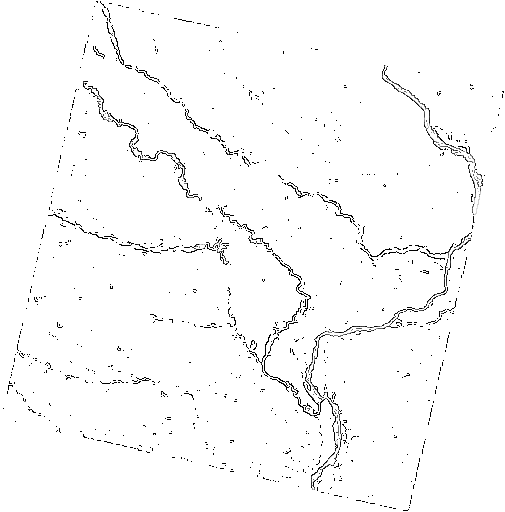

In [16]:
# Now adding a buffer (morphological dilation) to the edges equal to 1/2 the pixel size (30m / 2  = 15m). 
# Might want to tune this parameter

# Define a kernel (structuring element)
kernel = ee.Kernel.square(radius = 0.5, units = 'pixels')

# Dilate
buffered = canny.focal_max(kernel = kernel, iterations = 2)

# Mask MNDWI
mndwi_mask = mndwi.mask(buffered)

# visualize
url = mndwi_mask.getThumbUrl()
IPython.display.Image(url=url, format='png', embed=True)

In [50]:
# poly = ee.Geometry.Polygon()

histogram = mndwi_mask.select('MNDWI').reduceRegion(reducer = histogram)
# histogram = ee.Dictionary(histogram.get('MNDWI'))
histogram

# print(histogram)
# mndwi_mask.getInfo()

# ls5a = ls5.reduceRegion(ee.Reducer.frequencyHistogram(),landscapes,1000)
# ls5b = ee.Dictionary(ls5a.get('pc1'))
# return ls5b
# ee.Reducer.Histogram()
# hist = mndwi_mask.histogram(mndwi_mask, 30)

In [52]:
import ee
ee.Initialize()

table = ee.FeatureCollection('users/sntopp/Lakes_ply_20171106')
lakeNum = int(table.size().getInfo())
lakes = table.toList(lakeNum) 


collectionL5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')    .filter(ee.Filter.eq('WRS_PATH', 15))    .filter(ee.Filter.eq('WRS_ROW', 36))    .set({'Mission': 'L5'})

polygon = table.filter(ee.Filter.eq('GNIS_NAME', 'Salters Lake')).geometry()

image = ee.Image(collectionL5.filterBounds(polygon).filter(ee.Filter.date('1994-06-19','1994-06-21')).first())

ndwi = image.normalizedDifference(['B2','B5'])    #Landsat 5/7
#ndwi = image.normalizedDifference(['B3','B8'])       ##S2
histogram = ndwi.reduceRegion(ee.Reducer.histogram(50).combine('mean', 'None', True).combine('variance', 'None', True),polygon.buffer(1500),100, True)

def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sums = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sums.divide(total)
    indices = ee.List.sequence(1, size)
  
  ### Compute between sum of squares, where each mean partitions the data.
    def thresh2(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0]);
        aMeans = means.slice(0, 0, i);
        aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount)
        bCount = total.subtract(aCount)
        bMean = sums.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(bCount.multiply(bMean.subtract(mean).pow(2)))
    bss = indices.map(thresh2)

        #### Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])

threshold = otsu(histogram.get('nd_histogram'))
water = ndwi.gt(threshold)
cost = water.eq(0)
sources = ee.Image().toByte().paint(polygon.centroid().buffer(50), 1)
sources = sources.updateMask(sources)
cumulativeCost = cost.cumulativeCost(sources, 8000)
area = cumulativeCost.lt(1)
area = area.updateMask(area)
pArea = area.multiply(ee.Image.pixelArea())
areaSum = pArea.reduceRegion(ee.Reducer.sum(),polygon.buffer(2000), 30) #need to use same resolution as input (30 landsat)
image = ee.Image(image).set({"Area": areaSum.get("cumulative_cost")})

image.getInfo()


# In[ ]:



EEException: Projection: Argument 'crs': Invalid type. Expected: String. Actual: Type<Boolean>.

In [ ]:
def GetDataFrame(coords):
    
    pnt = ee.Geometry.Point(coords)
    # Sample for a time series of values at the point.
    geom_values = l8sr.filterBounds(pnt).select('ndvi').getRegion(geometry=pnt, scale=30)
    geom_values_list = ee.List(geom_values).getInfo()
    # Convert to a Pandas DataFrame.
    header = geom_values_list[0]
    data = pd.DataFrame(geom_values_list[1:], columns=header)
    data['datetime'] = pd.to_datetime(data['time'], unit='ms', utc=True)
    data.set_index('time')
    data = data.sort_values('datetime')
    data = data[['datetime', 'ndvi']]
    return data

***
## Notes

 - Canny edge detection and morphological dilation buffer? Used [here](https://www.mdpi.com/2072-4292/8/5/386)